In [58]:
import os
import torch
import pickle
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import cv2
from torchvision import models
from sklearn import preprocessing
from tqdm import tqdm
import random

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [60]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, normalize=None):
        self.dataset = dataset
        self.dataset_len = len(dataset)
        self.transform = transform
        self.normalize = normalize
        # self.dataset = np.transpose(dataset[0], (1, 2, 0))        

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        image, index = self.dataset[idx]
        w,h = image.size
        if w < h:
            resized_image = image.resize((224, int(224 * h / w)))
        else:
            resized_image = image.resize((int(224 * w / h), 224))
        w,h = resized_image.size
        image = resized_image.crop((w/2  - 112, h/2 - 112, w/2 + 112, h/2 + 112))
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)
            image = image/255
            image = self.normalize(image)

        # image = torch.tensor(image, dtype=torch.float32)
        
        # image = torch.transpose(image, 0, 2)
        # image = torch.transpose(image, 0, 1)
        # name = dataset.classes[index]
        # label = name.split('-')[1]
        # image = torch.transpose(image,0,-1)
        # image = torch.transpose(image,0,1)
        label = index
        
        # label = torch.tensor()
        return image, label

In [61]:
normalize = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [62]:
transform = transforms.Compose([
    transforms.PILToTensor(),
#     transforms.Resize((224, 224)), 
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(degrees = (0,20)),
    # transforms.GaussianBlur(5),
])

In [63]:
dataset = datasets.ImageFolder('/kaggle/input/stanford-dogs-dataset/images/Images')
dataset_len = len(dataset)

In [64]:
ImageDataset = CustomImageDataset(dataset, transform, normalize)

In [65]:
ImageDataset[0][0].shape

torch.Size([3, 224, 224])

In [15]:
labels_list = [0]*120
labels_names = []
for i in tqdm(range(dataset_len)):
    L = ImageDataset[i][1]
    labels_list[L] += 1
    label = dataset.classes[L].split('-')[1]
    if(label not in labels_names):
        labels_names.append(label)

100%|██████████| 20580/20580 [02:35<00:00, 132.55it/s]


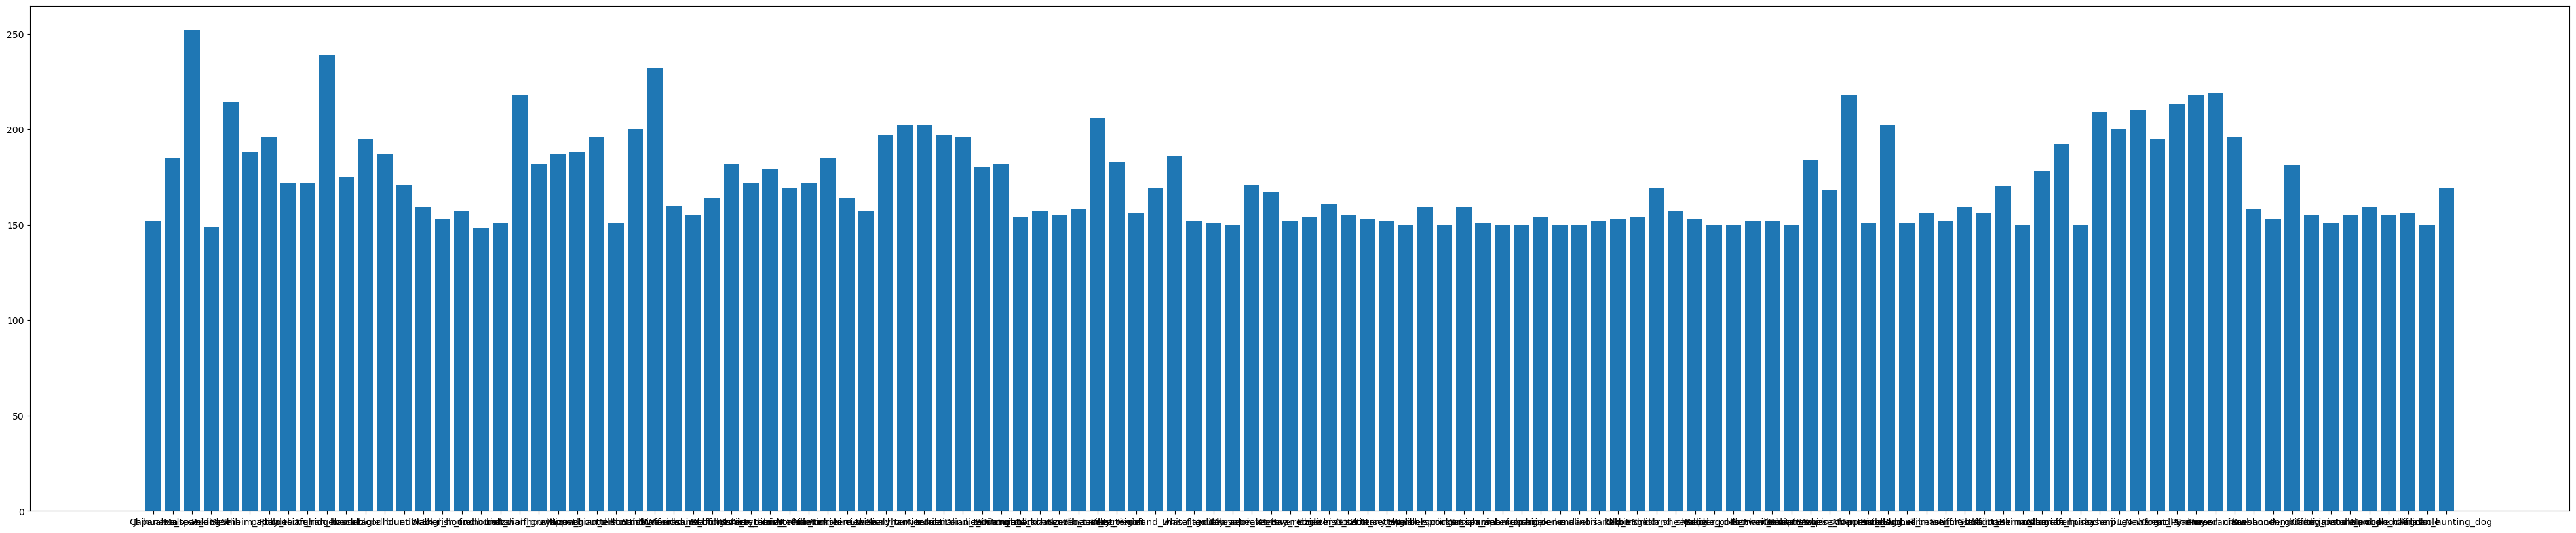

In [25]:
plt.figure(figsize=(50,10))
plt.bar(range(len(labels_list)), labels_list, tick_label=labels_names)

plt.show()

In [66]:
train_size = int(dataset_len*0.7)
test_size = int(dataset_len*0.1)
val_size = int(dataset_len*0.2)

In [74]:
def train_test_val_split():
  g = torch.Generator()
  g.manual_seed(42)
  indices = list(range(dataset_len))
  np.random.shuffle(indices)

  test_index = indices[:test_size]
  train_index = indices[test_size:test_size+train_size]
  val_index = indices[-val_size:]

  train_sampler=SubsetRandomSampler(train_index, generator=g)
  val_sampler=SubsetRandomSampler(val_index, generator=g)
  test_sampler=SubsetRandomSampler(test_index, generator=g)

  return train_sampler,val_sampler,test_sampler,indices

In [75]:
train_sampler,val_sampler,test_sampler,indices = train_test_val_split()

In [89]:
batch_size=32
trainloader = torch.utils.data.DataLoader(ImageDataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(ImageDataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)

In [77]:
filename = 'indices_fine-grain'
pickle.dump(indices, open(filename, 'wb'))
from IPython.display import FileLink
FileLink(r'indices_fine-grain')

/kaggle/working/indices_fine-grain

In [78]:
def accuracy_test(model,loader,criterion):
  correct = 0
  total = 0
  tot_loss = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data
                    
          images = images.float().to(device)
          # labels = labels.float().to(device)

          le = preprocessing.LabelEncoder()
          targets = le.fit_transform(labels)
          targets = torch.as_tensor(targets) 
             
          outputs = model(images)
          outputs = outputs.to(device)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          labels = labels.to(device)
          correct += (predicted == labels).sum().item()
          
          # outputs = outputs.argmax(1).to(torch.float64)
          labels = labels.to(torch.int64)
          labels = F.one_hot(labels, num_classes=120).to(torch.float64)

          loss = criterion(outputs, torch.max(labels, 1)[1])
          loss.requires_grad = True
          loss.backward()
          tot_loss += loss.item()


  Accuracy = 100 * correct / total
  Loss = tot_loss / total
  return Accuracy,Loss


In [79]:
def training(model,loader,criterion,optimizer,config,valloader):
  train_acc_arr = []
  train_loss_arr = []
  val_acc_arr = []
  val_loss_arr = []
  y_pred = []
  y_true = []

  for epoch in tqdm(range(config['epochs'])):

    example_ct = 0
    batch_ct = 0
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        labels_without_one_hot = labels.float().to(device)
        labels = F.one_hot(labels, num_classes=120)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        # labels = labels.argmax(1).to(torch.float64)
        outputs = model(inputs)
        # outputs = torch.argmax(outputs ,axis=1)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_without_one_hot).sum().item()

        loss = criterion(outputs, torch.max(labels, 1)[1])
        optimizer.zero_grad()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        example_ct +=  len(inputs)
        batch_ct += 1
        running_loss += loss.item()

        if ((batch_ct) % 10) == 0:
            print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
            print(f"Training Accuracy: {100*correct/total}")

    # train_acc, train_loss = accuracy_test(model,trainloader,criterion)
    train_acc = 100*correct/total
    train_loss = running_loss/total
    val_acc,val_loss = accuracy_test(model,valloader,criterion)
    print("VALIDATION ACC",val_acc)
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)

  print("Finished training")
  return train_acc_arr,train_loss_arr,val_acc_arr,val_loss_arr

In [80]:
def test(model, loader):
    model.eval()

    correct, total ,incorrect= 0, 0,0

    y_pred = []
    y_true = []

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data in loader:
          images, labels = data

          saved_images = images

          images = images.float().to(device)
          # images = torch.transpose(images,-1,1)
          labels = labels.float().to(device)
          
          outputs = model(images)
          outputs = outputs.to(device)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          predicted = predicted.to(device)
          correct += (predicted == labels).sum().item()

          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          
          # labels = labels.to(torch.int64)
          # labels = F.one_hot(labels, num_classes=10).to(torch.float64)

          # loss = criterion(outputs, labels)
          # loss.requires_grad = True
          # loss.backward()
          # tot_loss += loss.item()

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
    print(classification_report(y_true, y_pred))
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy of the model on the set of " + f"test images: {correct / total:%}")

    return y_true, y_pred

In [87]:
def model_pipeline(hyperparameters, trainloader, valloader, testloader, residual):

  # model = CNN().to(device)
  model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT).to(device)
#   model = models.resnet50(pretrained=True).to(device)

  criterion = nn.CrossEntropyLoss()
  #optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)
  optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

  # and use them to train the model
  train_acc,train_loss,val_acc,val_loss = training(model, trainloader, criterion, optimizer, config,testloader)


  # and test its final performance
  test_true, test_pred = test(model, testloader)


  print("FINISHED")

  return test_true, test_pred,train_acc,train_loss,val_acc,val_loss, model

In [82]:
config = dict(
    epochs=10,
    classes=120,
    batch_size=128,
    learning_rate=0.0001,
    dataset="MNIST",
    architecture="CNN")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 01280 examples: 6.782
Training Accuracy: 0.703125
Loss after 02560 examples: 4.699
Training Accuracy: 3.125
Loss after 03840 examples: 3.430
Training Accuracy: 7.109375
Loss after 05120 examples: 2.884
Training Accuracy: 12.421875
Loss after 06400 examples: 2.220
Training Accuracy: 17.984375
Loss after 07680 examples: 1.708
Training Accuracy: 23.580729166666668
Loss after 08960 examples: 1.466
Training Accuracy: 28.325892857142858
Loss after 10240 examples: 1.412
Training Accuracy: 32.83203125
Loss after 11520 examples: 1.283
Training Accuracy: 36.588541666666664
Loss after 12800 examples: 1.033
Training Accuracy: 39.75
Loss after 14080 examples: 1.039
Training Accuracy: 42.62784090909091


 10%|█         | 1/10 [03:25<30:49, 205.48s/it]

VALIDATION ACC 73.12925170068027
Loss after 01280 examples: 0.509
Training Accuracy: 86.640625
Loss after 02560 examples: 0.539
Training Accuracy: 86.484375
Loss after 03840 examples: 0.507
Training Accuracy: 86.5625
Loss after 05120 examples: 0.505
Training Accuracy: 86.89453125
Loss after 06400 examples: 0.538
Training Accuracy: 86.921875
Loss after 07680 examples: 0.409
Training Accuracy: 86.82291666666667
Loss after 08960 examples: 0.429
Training Accuracy: 86.59598214285714
Loss after 10240 examples: 0.592
Training Accuracy: 86.54296875
Loss after 11520 examples: 0.568
Training Accuracy: 86.47569444444444
Loss after 12800 examples: 0.469
Training Accuracy: 86.3671875
Loss after 14080 examples: 0.476
Training Accuracy: 86.37073863636364


 20%|██        | 2/10 [06:50<27:21, 205.13s/it]

VALIDATION ACC 76.67638483965014
Loss after 01280 examples: 0.234
Training Accuracy: 96.5625
Loss after 02560 examples: 0.148
Training Accuracy: 96.6796875
Loss after 03840 examples: 0.187
Training Accuracy: 96.90104166666667
Loss after 05120 examples: 0.123
Training Accuracy: 97.08984375
Loss after 06400 examples: 0.133
Training Accuracy: 97.09375
Loss after 07680 examples: 0.161
Training Accuracy: 97.17447916666667
Loss after 08960 examples: 0.106
Training Accuracy: 97.31026785714286
Loss after 10240 examples: 0.076
Training Accuracy: 97.40234375
Loss after 11520 examples: 0.128
Training Accuracy: 97.43055555555556
Loss after 12800 examples: 0.101
Training Accuracy: 97.4296875
Loss after 14080 examples: 0.170
Training Accuracy: 97.44318181818181


 30%|███       | 3/10 [10:15<23:56, 205.15s/it]

VALIDATION ACC 78.3284742468416
Loss after 01280 examples: 0.027
Training Accuracy: 99.453125
Loss after 02560 examples: 0.042
Training Accuracy: 99.4140625
Loss after 03840 examples: 0.028
Training Accuracy: 99.53125
Loss after 05120 examples: 0.030
Training Accuracy: 99.5703125
Loss after 06400 examples: 0.057
Training Accuracy: 99.578125
Loss after 07680 examples: 0.037
Training Accuracy: 99.58333333333333
Loss after 08960 examples: 0.030
Training Accuracy: 99.57589285714286
Loss after 10240 examples: 0.029
Training Accuracy: 99.5703125
Loss after 11520 examples: 0.026
Training Accuracy: 99.54861111111111
Loss after 12800 examples: 0.046
Training Accuracy: 99.515625
Loss after 14080 examples: 0.096
Training Accuracy: 99.48863636363636


 40%|████      | 4/10 [13:40<20:31, 205.27s/it]

VALIDATION ACC 78.86297376093295
Loss after 01280 examples: 0.021
Training Accuracy: 99.6875
Loss after 02560 examples: 0.016
Training Accuracy: 99.8046875
Loss after 03840 examples: 0.028
Training Accuracy: 99.84375
Loss after 05120 examples: 0.031
Training Accuracy: 99.765625
Loss after 06400 examples: 0.018
Training Accuracy: 99.765625
Loss after 07680 examples: 0.013
Training Accuracy: 99.75260416666667
Loss after 08960 examples: 0.014
Training Accuracy: 99.75446428571429
Loss after 10240 examples: 0.010
Training Accuracy: 99.765625
Loss after 11520 examples: 0.012
Training Accuracy: 99.78298611111111
Loss after 12800 examples: 0.015
Training Accuracy: 99.7734375
Loss after 14080 examples: 0.073
Training Accuracy: 99.765625


 50%|█████     | 5/10 [17:07<17:08, 205.75s/it]

VALIDATION ACC 79.64042759961127
Loss after 01280 examples: 0.010
Training Accuracy: 99.921875
Loss after 02560 examples: 0.009
Training Accuracy: 99.921875
Loss after 03840 examples: 0.007
Training Accuracy: 99.94791666666667
Loss after 05120 examples: 0.021
Training Accuracy: 99.921875
Loss after 06400 examples: 0.034
Training Accuracy: 99.875
Loss after 07680 examples: 0.007
Training Accuracy: 99.85677083333333
Loss after 08960 examples: 0.007
Training Accuracy: 99.85491071428571
Loss after 10240 examples: 0.038
Training Accuracy: 99.82421875
Loss after 11520 examples: 0.009
Training Accuracy: 99.81770833333333
Loss after 12800 examples: 0.007
Training Accuracy: 99.8125
Loss after 14080 examples: 0.011
Training Accuracy: 99.78693181818181


 60%|██████    | 6/10 [20:35<13:45, 206.45s/it]

VALIDATION ACC 78.66861030126336
Loss after 01280 examples: 0.063
Training Accuracy: 99.375
Loss after 02560 examples: 0.008
Training Accuracy: 99.6484375
Loss after 03840 examples: 0.005
Training Accuracy: 99.66145833333333
Loss after 05120 examples: 0.006
Training Accuracy: 99.70703125
Loss after 06400 examples: 0.009
Training Accuracy: 99.71875
Loss after 07680 examples: 0.015
Training Accuracy: 99.71354166666667
Loss after 08960 examples: 0.005
Training Accuracy: 99.73214285714286
Loss after 10240 examples: 0.005
Training Accuracy: 99.736328125
Loss after 11520 examples: 0.008
Training Accuracy: 99.75694444444444
Loss after 12800 examples: 0.005
Training Accuracy: 99.78125
Loss after 14080 examples: 0.028
Training Accuracy: 99.77982954545455


 70%|███████   | 7/10 [23:54<10:12, 204.07s/it]

VALIDATION ACC 79.68901846452867
Loss after 01280 examples: 0.004
Training Accuracy: 99.84375
Loss after 02560 examples: 0.005
Training Accuracy: 99.8828125
Loss after 03840 examples: 0.031
Training Accuracy: 99.84375
Loss after 05120 examples: 0.027
Training Accuracy: 99.84375
Loss after 06400 examples: 0.005
Training Accuracy: 99.828125
Loss after 07680 examples: 0.004
Training Accuracy: 99.84375
Loss after 08960 examples: 0.004
Training Accuracy: 99.81026785714286
Loss after 10240 examples: 0.003
Training Accuracy: 99.814453125
Loss after 11520 examples: 0.013
Training Accuracy: 99.82638888888889
Loss after 12800 examples: 0.004
Training Accuracy: 99.8125
Loss after 14080 examples: 0.022
Training Accuracy: 99.80823863636364


 80%|████████  | 8/10 [27:12<06:44, 202.19s/it]

VALIDATION ACC 79.64042759961127
Loss after 01280 examples: 0.012
Training Accuracy: 99.6875
Loss after 02560 examples: 0.058
Training Accuracy: 99.765625
Loss after 03840 examples: 0.003
Training Accuracy: 99.79166666666667
Loss after 05120 examples: 0.004
Training Accuracy: 99.82421875
Loss after 06400 examples: 0.005
Training Accuracy: 99.84375
Loss after 07680 examples: 0.004
Training Accuracy: 99.81770833333333
Loss after 08960 examples: 0.003
Training Accuracy: 99.79910714285714
Loss after 10240 examples: 0.036
Training Accuracy: 99.794921875
Loss after 11520 examples: 0.015
Training Accuracy: 99.79166666666667
Loss after 12800 examples: 0.003
Training Accuracy: 99.796875
Loss after 14080 examples: 0.020
Training Accuracy: 99.765625


 90%|█████████ | 9/10 [30:30<03:20, 200.68s/it]

VALIDATION ACC 79.3488824101069
Loss after 01280 examples: 0.003
Training Accuracy: 99.84375
Loss after 02560 examples: 0.012
Training Accuracy: 99.8828125
Loss after 03840 examples: 0.003
Training Accuracy: 99.765625
Loss after 05120 examples: 0.003
Training Accuracy: 99.78515625
Loss after 06400 examples: 0.003
Training Accuracy: 99.8125
Loss after 07680 examples: 0.003
Training Accuracy: 99.81770833333333
Loss after 08960 examples: 0.050
Training Accuracy: 99.77678571428571
Loss after 10240 examples: 0.013
Training Accuracy: 99.775390625
Loss after 11520 examples: 0.003
Training Accuracy: 99.77430555555556
Loss after 12800 examples: 0.003
Training Accuracy: 99.765625
Loss after 14080 examples: 0.028
Training Accuracy: 99.77272727272727


100%|██████████| 10/10 [33:47<00:00, 202.80s/it]

VALIDATION ACC 79.54324586977648
Finished training


              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76        14
         1.0       0.96      0.88      0.92        25
         2.0       0.85      0.93      0.89        30
         3.0       1.00      0.86      0.92        14
         4.0       0.62      0.50      0.56        20
         5.0       0.85      1.00      0.92        22
         6.0       0.80      0.89      0.84         9
         7.0       0.69      0.56      0.62        16
         8.0       0.64      0.60      0.62        15
         9.0       1.00      0.87      0.93        30
        10.0       0.88      0.82      0.85        17
        11.0       0.84      0.80      0.82        20
        12.0       0.94      0.94      0.94        18
        13.0       0.88      0.78      0.82        18
        14.0       0.93      0.72      0.81        18
        15.0       0.60      0.64      0.62        14
        16.0       0.50      0.50      0.50        12
        17.0       0.81    

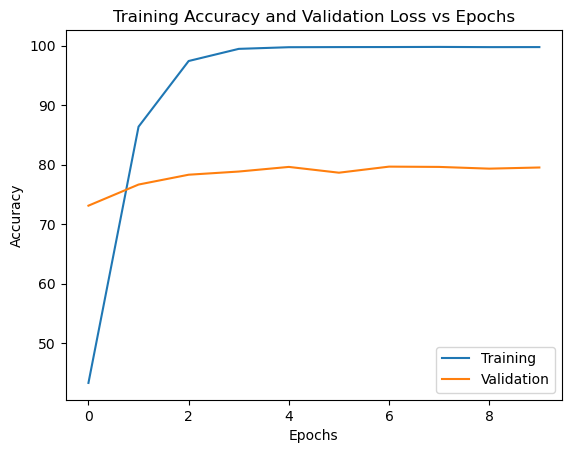

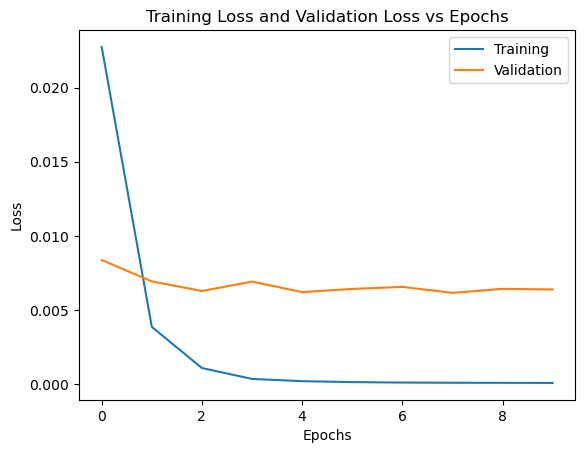

In [83]:
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [84]:
%cd /kaggle/working

/kaggle/working


In [85]:
filename = 'resnet50_final'
pickle.dump(model, open(filename, 'wb'))

In [86]:
from IPython.display import FileLink
FileLink(r'resnet50_final')

/kaggle/working/resnet50_final

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 00320 examples: 7.455
Training Accuracy: 0.0
Loss after 00640 examples: 6.797
Training Accuracy: 0.0
Loss after 00960 examples: 6.623
Training Accuracy: 0.10416666666666667
Loss after 01280 examples: 6.254
Training Accuracy: 0.3125
Loss after 01600 examples: 5.934
Training Accuracy: 0.3125
Loss after 01920 examples: 5.828
Training Accuracy: 0.46875
Loss after 02240 examples: 5.326
Training Accuracy: 0.625
Loss after 02560 examples: 5.418
Training Accuracy: 0.78125
Loss after 02880 examples: 5.294
Training Accuracy: 0.9722222222222222
Loss after 03200 examples: 4.963
Training Accuracy: 1.34375
Loss after 03520 examples: 4.689
Training Accuracy: 1.8181818181818181
Loss after 03840 examples: 4.674
Training Accuracy: 2.265625
Loss after 04160 examples: 4.116
Training Accuracy: 2.7163461538461537
Loss after 04480 examples: 3.831
Training Accuracy: 3.28125
Loss after 04800 examples: 4.047
Training Accuracy: 3.7291666666666665
Loss after 05120 examples: 3.872
Training Accuracy: 4.2

 10%|█         | 1/10 [02:48<25:14, 168.28s/it]

VALIDATION ACC 50.43731778425656
Loss after 00320 examples: 1.255
Training Accuracy: 61.25
Loss after 00640 examples: 1.928
Training Accuracy: 60.78125
Loss after 00960 examples: 1.476
Training Accuracy: 61.458333333333336
Loss after 01280 examples: 1.479
Training Accuracy: 61.40625
Loss after 01600 examples: 1.440
Training Accuracy: 61.6875
Loss after 01920 examples: 1.539
Training Accuracy: 61.5625
Loss after 02240 examples: 1.894
Training Accuracy: 60.75892857142857
Loss after 02560 examples: 1.325
Training Accuracy: 61.0546875
Loss after 02880 examples: 1.520
Training Accuracy: 61.21527777777778
Loss after 03200 examples: 1.383
Training Accuracy: 61.1875
Loss after 03520 examples: 1.446
Training Accuracy: 61.16477272727273
Loss after 03840 examples: 1.467
Training Accuracy: 61.380208333333336
Loss after 04160 examples: 1.050
Training Accuracy: 61.46634615384615
Loss after 04480 examples: 1.073
Training Accuracy: 61.607142857142854
Loss after 04800 examples: 1.511
Training Accuracy:

 20%|██        | 2/10 [05:36<22:26, 168.34s/it]

VALIDATION ACC 62.82798833819242
Loss after 00320 examples: 1.016
Training Accuracy: 72.5
Loss after 00640 examples: 0.765
Training Accuracy: 74.375
Loss after 00960 examples: 0.743
Training Accuracy: 73.95833333333333
Loss after 01280 examples: 0.593
Training Accuracy: 74.6875
Loss after 01600 examples: 0.790
Training Accuracy: 74.0
Loss after 01920 examples: 0.808
Training Accuracy: 74.375
Loss after 02240 examples: 0.833
Training Accuracy: 75.58035714285714
Loss after 02560 examples: 0.837
Training Accuracy: 75.8984375
Loss after 02880 examples: 0.823
Training Accuracy: 75.625
Loss after 03200 examples: 0.701
Training Accuracy: 75.875
Loss after 03520 examples: 0.824
Training Accuracy: 76.05113636363636
Loss after 03840 examples: 1.052
Training Accuracy: 76.14583333333333
Loss after 04160 examples: 1.070
Training Accuracy: 75.79326923076923
Loss after 04480 examples: 0.839
Training Accuracy: 76.02678571428571
Loss after 04800 examples: 0.480
Training Accuracy: 76.25
Loss after 05120

 30%|███       | 3/10 [08:26<19:43, 169.12s/it]

VALIDATION ACC 66.1807580174927
Loss after 00320 examples: 0.555
Training Accuracy: 80.9375
Loss after 00640 examples: 0.341
Training Accuracy: 83.59375
Loss after 00960 examples: 0.431
Training Accuracy: 85.0
Loss after 01280 examples: 0.387
Training Accuracy: 84.296875
Loss after 01600 examples: 0.415
Training Accuracy: 84.8125
Loss after 01920 examples: 0.347
Training Accuracy: 84.79166666666667
Loss after 02240 examples: 0.396
Training Accuracy: 84.82142857142857
Loss after 02560 examples: 0.452
Training Accuracy: 85.1953125
Loss after 02880 examples: 0.572
Training Accuracy: 84.58333333333333
Loss after 03200 examples: 0.600
Training Accuracy: 85.1875
Loss after 03520 examples: 0.574
Training Accuracy: 85.22727272727273
Loss after 03840 examples: 0.466
Training Accuracy: 85.234375
Loss after 04160 examples: 0.397
Training Accuracy: 84.8798076923077
Loss after 04480 examples: 0.867
Training Accuracy: 84.91071428571429
Loss after 04800 examples: 0.916
Training Accuracy: 84.916666666

 40%|████      | 4/10 [11:14<16:51, 168.56s/it]

VALIDATION ACC 68.17298347910592
Loss after 00320 examples: 0.265
Training Accuracy: 91.25
Loss after 00640 examples: 0.439
Training Accuracy: 92.03125
Loss after 00960 examples: 0.259
Training Accuracy: 91.875
Loss after 01280 examples: 0.380
Training Accuracy: 91.484375
Loss after 01600 examples: 0.347
Training Accuracy: 91.3125
Loss after 01920 examples: 0.432
Training Accuracy: 90.67708333333333
Loss after 02240 examples: 0.407
Training Accuracy: 90.49107142857143
Loss after 02560 examples: 0.790
Training Accuracy: 90.46875
Loss after 02880 examples: 0.271
Training Accuracy: 90.41666666666667
Loss after 03200 examples: 0.458
Training Accuracy: 89.96875
Loss after 03520 examples: 0.404
Training Accuracy: 89.85795454545455
Loss after 03840 examples: 0.465
Training Accuracy: 89.6875
Loss after 04160 examples: 0.414
Training Accuracy: 89.61538461538461
Loss after 04480 examples: 0.238
Training Accuracy: 89.55357142857143
Loss after 04800 examples: 0.512
Training Accuracy: 89.25
Loss af

 50%|█████     | 5/10 [14:00<13:59, 167.81s/it]

VALIDATION ACC 69.67930029154519
Loss after 00320 examples: 0.397
Training Accuracy: 96.5625
Loss after 00640 examples: 0.233
Training Accuracy: 96.09375
Loss after 00960 examples: 0.211
Training Accuracy: 95.52083333333333
Loss after 01280 examples: 0.505
Training Accuracy: 94.6875
Loss after 01600 examples: 0.222
Training Accuracy: 94.625
Loss after 01920 examples: 0.403
Training Accuracy: 93.80208333333333
Loss after 02240 examples: 0.193
Training Accuracy: 94.15178571428571
Loss after 02560 examples: 0.335
Training Accuracy: 94.1015625
Loss after 02880 examples: 0.350
Training Accuracy: 93.64583333333333
Loss after 03200 examples: 0.195
Training Accuracy: 93.71875
Loss after 03520 examples: 0.283
Training Accuracy: 93.57954545454545
Loss after 03840 examples: 0.385
Training Accuracy: 93.56770833333333
Loss after 04160 examples: 0.317
Training Accuracy: 93.77403846153847
Loss after 04480 examples: 0.351
Training Accuracy: 93.77232142857143
Loss after 04800 examples: 0.279
Training A

 60%|██████    | 6/10 [16:47<11:09, 167.33s/it]

VALIDATION ACC 71.6715257531584
Loss after 00320 examples: 0.093
Training Accuracy: 96.25
Loss after 00640 examples: 0.137
Training Accuracy: 95.9375
Loss after 00960 examples: 0.087
Training Accuracy: 95.0
Loss after 01280 examples: 0.209
Training Accuracy: 95.390625
Loss after 01600 examples: 0.272
Training Accuracy: 95.9375
Loss after 01920 examples: 0.206
Training Accuracy: 95.9375
Loss after 02240 examples: 0.287
Training Accuracy: 95.84821428571429
Loss after 02560 examples: 0.190
Training Accuracy: 95.8203125
Loss after 02880 examples: 0.209
Training Accuracy: 95.79861111111111
Loss after 03200 examples: 0.229
Training Accuracy: 95.90625
Loss after 03520 examples: 0.119
Training Accuracy: 95.82386363636364
Loss after 03840 examples: 0.351
Training Accuracy: 95.859375
Loss after 04160 examples: 0.221
Training Accuracy: 95.9375
Loss after 04480 examples: 0.259
Training Accuracy: 95.84821428571429
Loss after 04800 examples: 0.117
Training Accuracy: 95.89583333333333
Loss after 0512

 70%|███████   | 7/10 [19:34<08:21, 167.18s/it]

VALIDATION ACC 70.40816326530613
Loss after 00320 examples: 0.166
Training Accuracy: 97.5
Loss after 00640 examples: 0.186
Training Accuracy: 97.8125
Loss after 00960 examples: 0.191
Training Accuracy: 97.70833333333333
Loss after 01280 examples: 0.113
Training Accuracy: 97.5
Loss after 01600 examples: 0.144
Training Accuracy: 97.4375
Loss after 01920 examples: 0.109
Training Accuracy: 97.60416666666667
Loss after 02240 examples: 0.088
Training Accuracy: 97.8125
Loss after 02560 examples: 0.149
Training Accuracy: 97.734375
Loss after 02880 examples: 0.120
Training Accuracy: 97.84722222222223
Loss after 03200 examples: 0.095
Training Accuracy: 97.71875
Loss after 03520 examples: 0.159
Training Accuracy: 97.69886363636364
Loss after 03840 examples: 0.233
Training Accuracy: 97.63020833333333
Loss after 04160 examples: 0.153
Training Accuracy: 97.54807692307692
Loss after 04480 examples: 0.084
Training Accuracy: 97.52232142857143
Loss after 04800 examples: 0.072
Training Accuracy: 97.52083

 80%|████████  | 8/10 [22:19<05:33, 166.75s/it]

VALIDATION ACC 69.97084548104957
Loss after 00320 examples: 0.056
Training Accuracy: 97.8125
Loss after 00640 examples: 0.142
Training Accuracy: 97.8125
Loss after 00960 examples: 0.208
Training Accuracy: 97.70833333333333
Loss after 01280 examples: 0.084
Training Accuracy: 97.96875
Loss after 01600 examples: 0.221
Training Accuracy: 97.8125
Loss after 01920 examples: 0.108
Training Accuracy: 97.76041666666667
Loss after 02240 examples: 0.103
Training Accuracy: 97.90178571428571
Loss after 02560 examples: 0.118
Training Accuracy: 97.7734375
Loss after 02880 examples: 0.084
Training Accuracy: 97.74305555555556
Loss after 03200 examples: 0.094
Training Accuracy: 97.78125
Loss after 03520 examples: 0.207
Training Accuracy: 97.7840909090909
Loss after 03840 examples: 0.091
Training Accuracy: 97.8125
Loss after 04160 examples: 0.092
Training Accuracy: 97.76442307692308
Loss after 04480 examples: 0.077
Training Accuracy: 97.79017857142857
Loss after 04800 examples: 0.064
Training Accuracy: 9

 90%|█████████ | 9/10 [25:05<02:46, 166.42s/it]

VALIDATION ACC 69.04761904761905
Loss after 00320 examples: 0.077
Training Accuracy: 98.125
Loss after 00640 examples: 0.065
Training Accuracy: 98.4375
Loss after 00960 examples: 0.108
Training Accuracy: 98.33333333333333
Loss after 01280 examples: 0.067
Training Accuracy: 98.359375
Loss after 01600 examples: 0.055
Training Accuracy: 98.5
Loss after 01920 examples: 0.042
Training Accuracy: 98.59375
Loss after 02240 examples: 0.048
Training Accuracy: 98.52678571428571
Loss after 02560 examples: 0.091
Training Accuracy: 98.59375
Loss after 02880 examples: 0.033
Training Accuracy: 98.71527777777777
Loss after 03200 examples: 0.046
Training Accuracy: 98.75
Loss after 03520 examples: 0.148
Training Accuracy: 98.66477272727273
Loss after 03840 examples: 0.058
Training Accuracy: 98.69791666666667
Loss after 04160 examples: 0.100
Training Accuracy: 98.79807692307692
Loss after 04480 examples: 0.113
Training Accuracy: 98.81696428571429
Loss after 04800 examples: 0.029
Training Accuracy: 98.8333

100%|██████████| 10/10 [27:51<00:00, 167.19s/it]

VALIDATION ACC 70.84548104956268
Finished training


              precision    recall  f1-score   support

         0.0       0.55      0.43      0.48        14
         1.0       0.77      0.92      0.84        25
         2.0       0.73      0.90      0.81        30
         3.0       0.75      0.86      0.80        14
         4.0       0.61      0.55      0.58        20
         5.0       0.92      1.00      0.96        22
         6.0       0.78      0.78      0.78         9
         7.0       0.62      0.50      0.55        16
         8.0       0.53      0.60      0.56        15
         9.0       0.96      0.83      0.89        30
        10.0       0.86      0.71      0.77        17
        11.0       0.83      0.95      0.88        20
        12.0       0.83      0.83      0.83        18
        13.0       0.94      0.83      0.88        18
        14.0       0.85      0.61      0.71        18
        15.0       0.71      0.71      0.71        14
        16.0       0.57      0.67      0.62        12
        17.0       0.62    

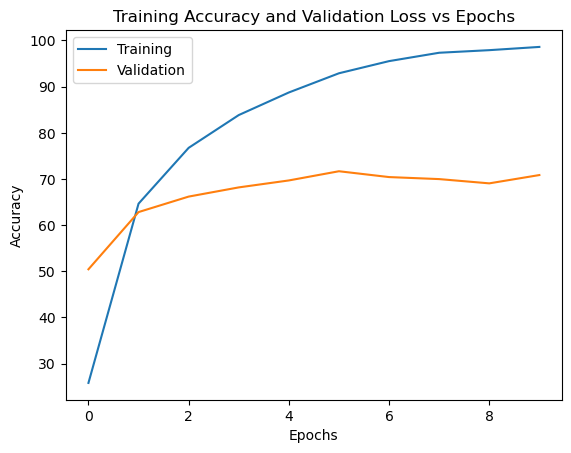

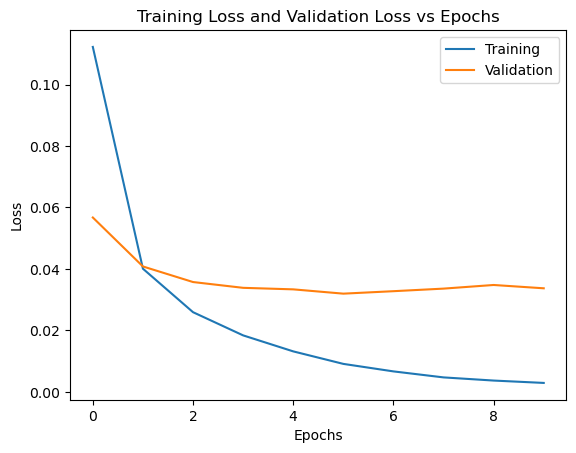

In [90]:
test_true, test_pred ,train_acc,train_loss,val_acc,val_loss, model = model_pipeline(config, trainloader, valloader, testloader, False)
x = range(config["epochs"])
plt.plot(x,train_acc,label="Training")
plt.plot(x,val_acc,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy and Validation Loss vs Epochs")
plt.show()
x = range(config["epochs"])
plt.plot(x,train_loss,label="Training")
plt.plot(x,val_loss,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss and Validation Loss vs Epochs")
plt.show()
filename = '/resnet50'
pickle.dump(model, open(filename, 'wb'))

In [91]:
%cd /kaggle/working

/kaggle/working


In [92]:
filename = 'mobileNet32_final'
pickle.dump(model, open(filename, 'wb'))

In [93]:
from IPython.display import FileLink
FileLink(r'mobileNet32_final')

/kaggle/working/mobileNet32_final

In [94]:
!pip freeze > requirements.txt

Virtal Environment for testing

In [98]:
indices = pickle.load(open('/kaggle/input/indices/indices_fine-grain', 'rb'))

In [99]:
g = torch.Generator()
g.manual_seed(42)

In [100]:
test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

In [101]:
batch_size=128
trainloader = torch.utils.data.DataLoader(ImageDataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(ImageDataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(ImageDataset, sampler = test_sampler, batch_size=batch_size)

In [102]:
pickled_model = pickle.load(open('/kaggle/input/resnet50-final/resnet50_final', 'rb'))
test_true, test_pred = test(pickled_model, testloader)

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76        14
         1.0       0.96      0.88      0.92        25
         2.0       0.85      0.93      0.89        30
         3.0       1.00      0.86      0.92        14
         4.0       0.62      0.50      0.56        20
         5.0       0.85      1.00      0.92        22
         6.0       0.80      0.89      0.84         9
         7.0       0.69      0.56      0.62        16
         8.0       0.64      0.60      0.62        15
         9.0       1.00      0.87      0.93        30
        10.0       0.88      0.82      0.85        17
        11.0       0.84      0.80      0.82        20
        12.0       0.94      0.94      0.94        18
        13.0       0.88      0.78      0.82        18
        14.0       0.93      0.72      0.81        18
        15.0       0.60      0.64      0.62        14
        16.0       0.50      0.50      0.50        12
        17.0       0.81    

In [116]:
pickled_model = pickle.load(open('/kaggle/input/mobilenet/mobileNet32_final', 'rb'))
test_true, test_pred = test(pickled_model, testloader)

              precision    recall  f1-score   support

         0.0       0.55      0.43      0.48        14
         1.0       0.77      0.92      0.84        25
         2.0       0.73      0.90      0.81        30
         3.0       0.75      0.86      0.80        14
         4.0       0.61      0.55      0.58        20
         5.0       0.92      1.00      0.96        22
         6.0       0.78      0.78      0.78         9
         7.0       0.62      0.50      0.55        16
         8.0       0.53      0.60      0.56        15
         9.0       0.96      0.83      0.89        30
        10.0       0.86      0.71      0.77        17
        11.0       0.83      0.95      0.88        20
        12.0       0.83      0.83      0.83        18
        13.0       0.94      0.83      0.88        18
        14.0       0.85      0.61      0.71        18
        15.0       0.71      0.71      0.71        14
        16.0       0.57      0.67      0.62        12
        17.0       0.62    